In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import cartopy.crs as ccrs
import xarray as xr
import glob
import datetime as dt
import tqdm
from matplotlib.patches import Rectangle
import pytz
from matplotlib.lines import Line2D
from cartopy import geodesic
import shapely
from matplotlib.patches import ConnectionPatch
from scipy.stats import genpareto, pareto
from scipy.stats.mstats import mquantiles
import scipy.stats

## This notebook will contain all analysis that only requires loading event data. This data is small, and makes sense to group here. 

In [2]:
def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle="-")    

def add_lt(df,tz):
    df["lt"] = df.index.tz_localize(pytz.utc).tz_convert(pytz.timezone(tz))
    return df

def load_scws(rid,tz):
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,2:1,1:0})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    
    df1 = add_lt(df1,tz)    
        
    df1["year"] = df1.index.year
    df1["month"] = df1.index.month
    df1["hour"] = df1["lt"].dt.hour
    
    df1["rid"] = rid
    
    return df1

def remove_suspect_gusts(df):
    #Including the removal of Kurnell tornado
    dts = ["2010-12-14 07:03:00","2011-01-11 03:49:00","2015-12-15 23:33:00","2020-02-09 01:00:00","2020-02-09 03:18:00","2020-05-25 06:11:00",
          "2012-11-02 18:58:00","2012-12-20 21:19:00","2012-12-15 13:00:00","2012-12-29 16:15:00","2012-12-30 06:25:00","2012-12-30 18:01:00","2013-01-02 08:15:00",
          "2013-01-05 03:36:00","2013-01-12 15:22:00","2013-02-11 07:56:00"]
    return df[np.in1d(df.dt_utc,dts,invert=True)]


def assign_storm_class(data):
    data["aspect_ratio"] = data.major_axis_length / data.minor_axis_length     
    #Linear
    data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
    #Non-linear
    data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
    #Cellular
    data.loc[(data.local_max == 1),"class2"] = "Cellular"
    #Cluster of cells
    data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
    #Supercell
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
    #Linear hybrid
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.major_axis_length>=100)),"class2"] = "Embedded supercell"
    
    return data

In [38]:
tzs = {"68":'Australia/Melbourne',
       "64":'Australia/Adelaide',
       "8":'Australia/Brisbane',
       "72":'Australia/Queensland',
       "75":'Australia/Queensland',
       "19":'Australia/Queensland',
       "73":'Australia/Queensland',
       "78":'Australia/Queensland',
       "77":'Australia/Darwin',
       "49":'Australia/Victoria',
       "4":'Australia/Sydney',
       "40":'Australia/Canberra',
       "48":'Australia/West',
       "2":'Australia/Melbourne',
       "66":'Australia/Brisbane',
       "69":'Australia/NSW',
       "70":'Australia/Perth',
       "71":'Australia/Sydney',
      "63":'Australia/Darwin',
      "76":'Australia/Hobart',
      "77":"Australia/Darwin"}
       
rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","68","63","76","77"]
scws = [load_scws(rid,tzs[rid]) for rid in rids]
df_scw = remove_suspect_gusts(pd.concat(scws,axis=0))
print(str(df_scw.shape[0]) + " EVENTS")
print(str(df_scw.shape[0] - df_scw[df_scw.duplicated(["year","month","rid","uid10"],keep="first")].shape[0]),"UNIQUE PARENT-STORMS")

413 EVENTS
409 UNIQUE PARENT-STORMS


In [4]:
print("Tropical")
tropical_rids=["63","72","75","19","73","78",'77']
print(df_scw[np.in1d(df_scw.rid, tropical_rids)].cluster_new.value_counts().sort_index())
print("Sub-tropical coastal")
subtrop_rids=["4","8","66","71"]
print(df_scw[np.in1d(df_scw.rid, subtrop_rids)].cluster_new.value_counts().sort_index())
print("Inland")
inland_rids=["48","49","69"]
print(df_scw[np.in1d(df_scw.rid, inland_rids)].cluster_new.value_counts().sort_index())
print("Mid-latitude coastal")
midlat_rids=["70","2","68","64","76","40"]
print(df_scw[np.in1d(df_scw.rid, midlat_rids)].cluster_new.value_counts().sort_index())

Tropical
1     3
2    53
Name: cluster_new, dtype: int64
Sub-tropical coastal
0     7
1    21
2    66
Name: cluster_new, dtype: int64
Inland
0    11
1    26
2    36
Name: cluster_new, dtype: int64
Mid-latitude coastal
0    122
1     47
2     21
Name: cluster_new, dtype: int64


In [5]:
df_scw["wgr_sherb"] = df_scw["gust"] / df_scw["speed"]
print(df_scw.wgr_sherb.quantile([.25,0.5,0.75]))


0.25    1.102235
0.50    1.404057
0.75    1.899937
Name: wgr_sherb, dtype: float64


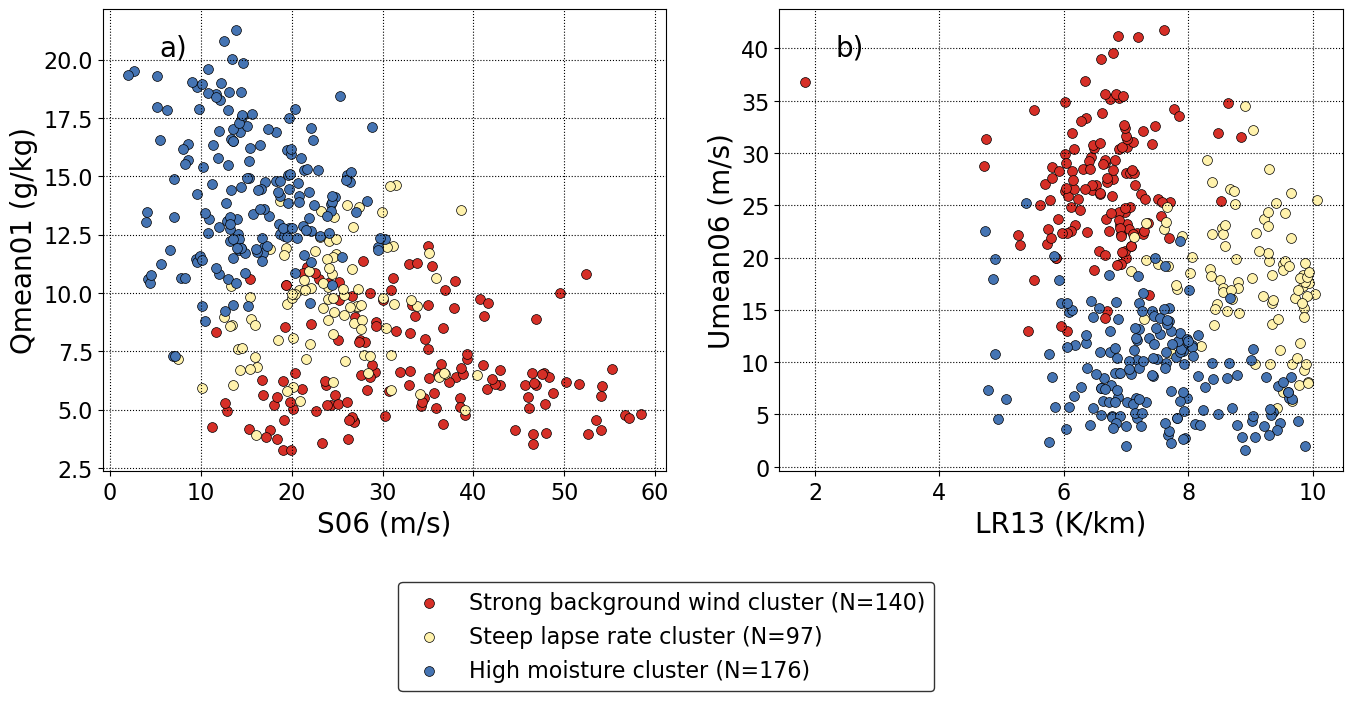

In [40]:
def get_2dhist(df):
    x_s06 = np.arange(0,42.5,2.5)
    y_qmean01 = np.arange(2,18,1)
    H1, xe_s06, ye_qmean01 = np.histogram2d(df.s06.values, df.qmean01.values, bins=[x_s06,y_qmean01],density=False)
    H1 = H1/(H1.sum()) * 100
    xc_s06 = np.array([(x_s06[i]+x_s06[i+1])/2 for i in np.arange(x_s06.shape[0]-1)])
    yc_qmean01 = np.array([(y_qmean01[i]+y_qmean01[i+1])/2 for i in np.arange(y_qmean01.shape[0]-1)])
    
    x_lr13 = np.arange(0,12,1)
    y_umean06 = np.arange(-2,27.5,2.5)
    H2, xe_lr13, ye_umean06 = np.histogram2d(df.lr13.values, df.Umean06.values, bins=[x_lr13,y_umean06],density=False)
    H2 = H2/(H2.sum()) * 100
    xc_lr13 = np.array([(x_lr13[i]+x_lr13[i+1])/2 for i in np.arange(x_lr13.shape[0]-1)])
    yc_umean06 = np.array([(y_umean06[i]+y_umean06[i+1])/2 for i in np.arange(y_umean06.shape[0]-1)])    
    
    return xc_s06, yc_qmean01, H1, xc_lr13, yc_umean06, H2



p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
plt.figure(figsize=[16,6])


levs=np.arange(0.5,4,0.5)

plt.subplot(1,2,1)

plt.ylabel("Qmean01")
plt.xlabel("S06")


plt.scatter(df_scw.query("cluster_new==0").s06, df_scw.query("cluster_new==0").qmean01,color=p[0],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="Strong background wind cluster (N="+str(df_scw.query("cluster_new==0").shape[0])+")")
plt.scatter(df_scw.query("cluster_new==1").s06, df_scw.query("cluster_new==1").qmean01,color=p[1],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="Steep lapse rate cluster (N="+str(df_scw.query("cluster_new==1").shape[0])+")")
plt.scatter(df_scw.query("cluster_new==2").s06, df_scw.query("cluster_new==2").qmean01,color=p[2],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="High moisture cluster (N="+str(df_scw.query("cluster_new==2").shape[0])+")")
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Qmean01 (g/kg)",size=20)
plt.gca().set_xlabel("S06 (m/s)",size=20)
plt.gca().text(0.1,0.9,"a)",transform=plt.gca().transAxes,size=20)

l=plt.legend(loc=8,fontsize=16,bbox_to_anchor=(1,-0.5),edgecolor="k")


levs=np.arange(1,11,1.5)

plt.subplot(1,2,2)
plt.ylabel("Umean06")
plt.xlabel("LR13")

plt.scatter(df_scw.query("cluster_new==0").lr13, df_scw.query("cluster_new==0").Umean06,color=p[0],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.scatter(df_scw.query("cluster_new==1").lr13, df_scw.query("cluster_new==1").Umean06,color=p[1],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.scatter(df_scw.query("cluster_new==2").lr13, df_scw.query("cluster_new==2").Umean06,color=p[2],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Umean06 (m/s)",size=20)
plt.gca().set_xlabel("LR13 (K/km)",size=20)
plt.gca().text(0.1,0.9,"b)",transform=plt.gca().transAxes,size=20)

plt.savefig("/g/data/eg3/ab4502/ExtremeWind/systematic_clusters.jpeg",dpi=400,bbox_inches="tight")

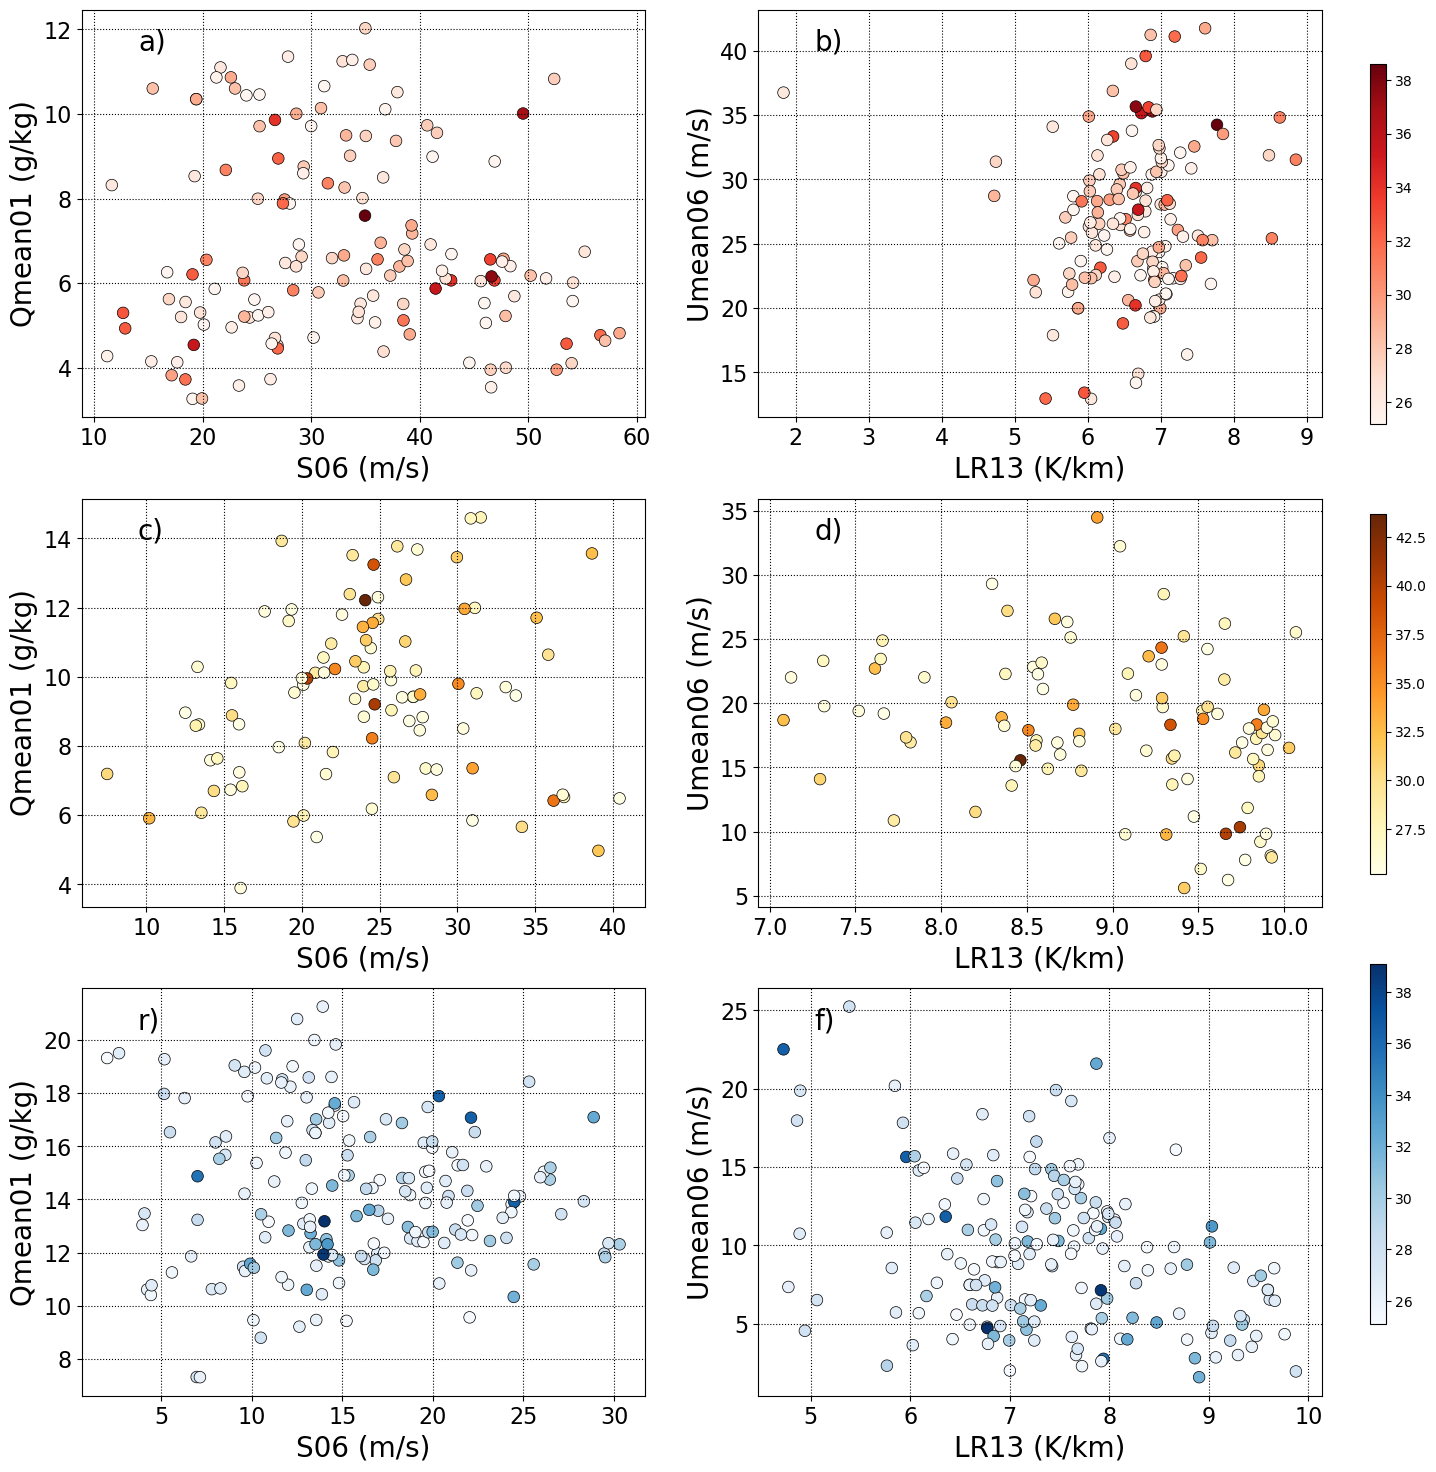

In [41]:
def temp_plot(c,ax1,ax2,cax,l1,l2,cmap):

    levs=np.arange(0.5,4,0.5)

    plt.ylabel("Qmean01")
    plt.xlabel("S06")


    c1=ax1.scatter(df_scw.query("cluster_new=="+c).s06, df_scw.query("cluster_new=="+c).qmean01,c=df_scw.query("cluster_new=="+c).gust,
                marker="o",s=70,edgecolor="k",linewidths=0.5,cmap=cmap,
                label="Steep lapse rate cluster (N="+str(df_scw.query("cluster_new=="+c).shape[0])+")")
    ax1.grid(color="k",ls=":")
    ax1.tick_params("both",labelsize=16)
    ax1.set_ylabel("Qmean01 (g/kg)",size=20)
    ax1.set_xlabel("S06 (m/s)",size=20)
    ax1.text(0.1,0.9,l1,transform=ax1.transAxes,size=20)

    levs=np.arange(1,11,1.5)

    plt.ylabel("Umean06")
    plt.xlabel("LR13")

    c2=ax2.scatter(df_scw.query("cluster_new=="+c).lr13, df_scw.query("cluster_new=="+c).Umean06,c=df_scw.query("cluster_new=="+c).gust,
                marker="o",s=70,edgecolor="k",linewidths=0.5,cmap=cmap)
    ax2.grid(color="k",ls=":")
    ax2.tick_params("both",labelsize=16)
    ax2.set_ylabel("Umean06 (m/s)",size=20)
    ax2.set_xlabel("LR13 (K/km)",size=20)
    ax2.text(0.1,0.9,l2,transform=ax2.transAxes,size=20)

    plt.colorbar(c2,cax=plt.axes(cax))
    
plt.figure(figsize=[16,18])

temp_plot("0",plt.subplot(3,2,1),plt.subplot(3,2,2),[0.93,0.65,0.01,0.2],"a)","b)",plt.get_cmap("Reds"))
temp_plot("1",plt.subplot(3,2,3),plt.subplot(3,2,4),[0.93,0.4,0.01,0.2],"c)","d)",plt.get_cmap("YlOrBr"))
temp_plot("2",plt.subplot(3,2,5),plt.subplot(3,2,6),[0.93,0.15,0.01,0.2],"r)","f)",plt.get_cmap("Blues"))

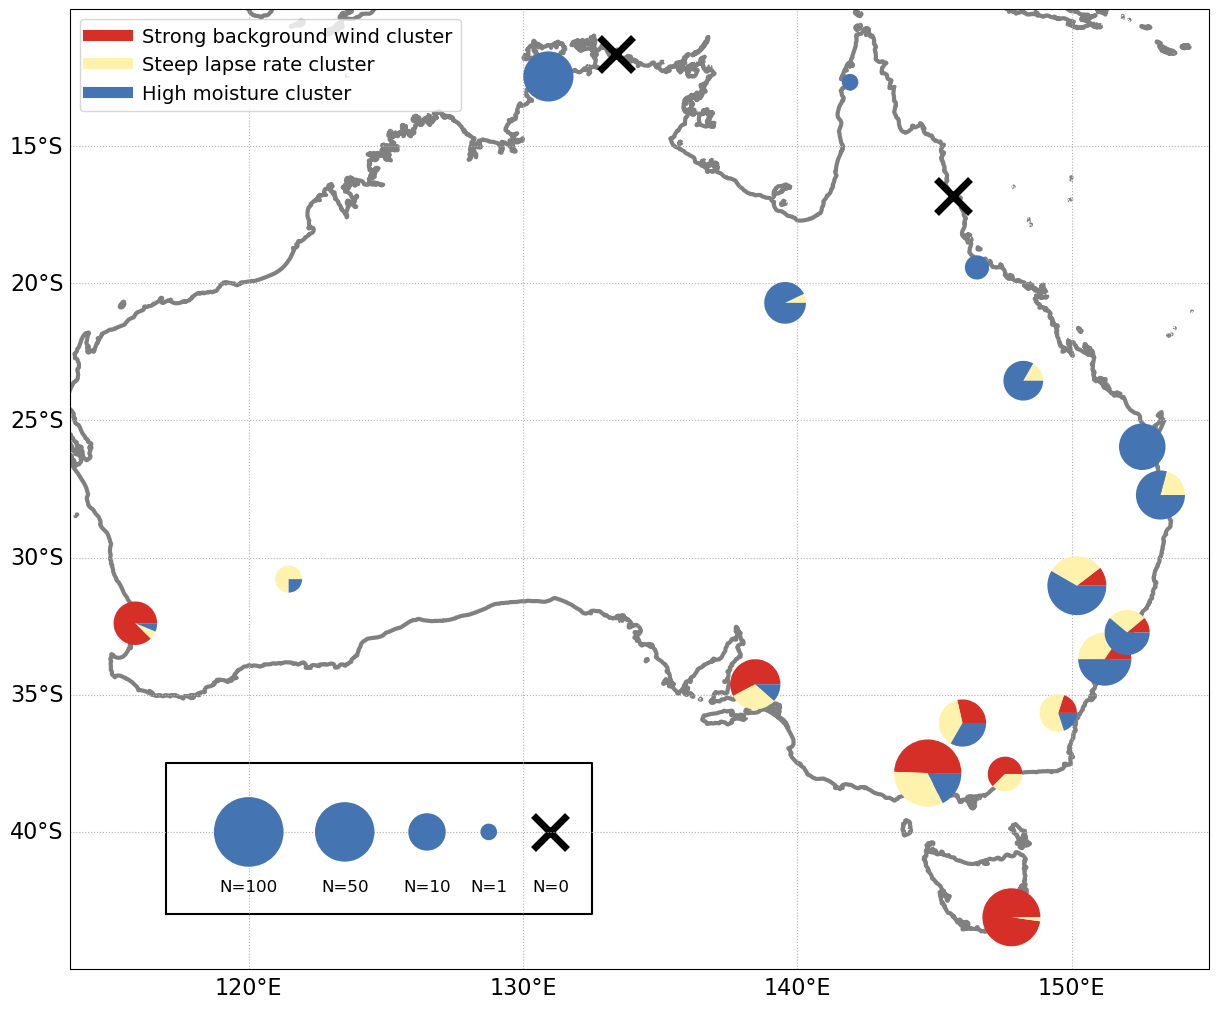

In [42]:
fig=plt.figure(figsize=[16,12])
ax0 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
ax0.coastlines("10m",color="gray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

for rid in rids:
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]   

    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)

    n_events = df_scw[df_scw.rid==rid].shape[0]
    #width_height = 0.08
    #width_height = n_events/153 * 0.1
    width_height = (np.log(n_events+2)/153) * 3
    
    if n_events > 0:
        ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                            width_height,width_height),anchor="C")
        ax1.pie([(df_scw[df_scw.rid==rid].cluster_new == c).sum() for c in [0,1,2]],
               colors=p)
    else:
        ax0.plot(lon0,lat0,"x",color="k",ms=25,mew=5)

    

n_events = 100
point = (120,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=100",ha="center",va="center",size=12)

n_events = 50
point = (123.5,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=50",ha="center",va="center",size=12)

n_events = 10
point = (126.5,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=10",ha="center",va="center",size=12)

n_events = 1
point = (128.75,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=1",ha="center",va="center",size=12)

n_events = 0
point = (131,-40)
ax0.plot(point[0],point[1],marker="x",ms=25,mew=5,color="k")
ax0.text(point[0],point[1]-2,"N=0",ha="center",va="center",size=12)

ax0.plot([117,117,132.5,132.5,117],[-43,-37.5,-37.5,-43,-43],color="k")


custom_lines = [Line2D([0], [0], color=p[0], lw=8),
                Line2D([0], [0], color=p[1], lw=8),
                Line2D([0], [0], color=p[2], lw=8)]
plt.legend(custom_lines, ["Strong background wind cluster","Steep lapse rate cluster","High moisture cluster"], fontsize=14,loc=2)    

plt.savefig("/g/data/eg3/ab4502/ExtremeWind/cluster_map.jpeg",dpi=400,bbox_inches="tight")

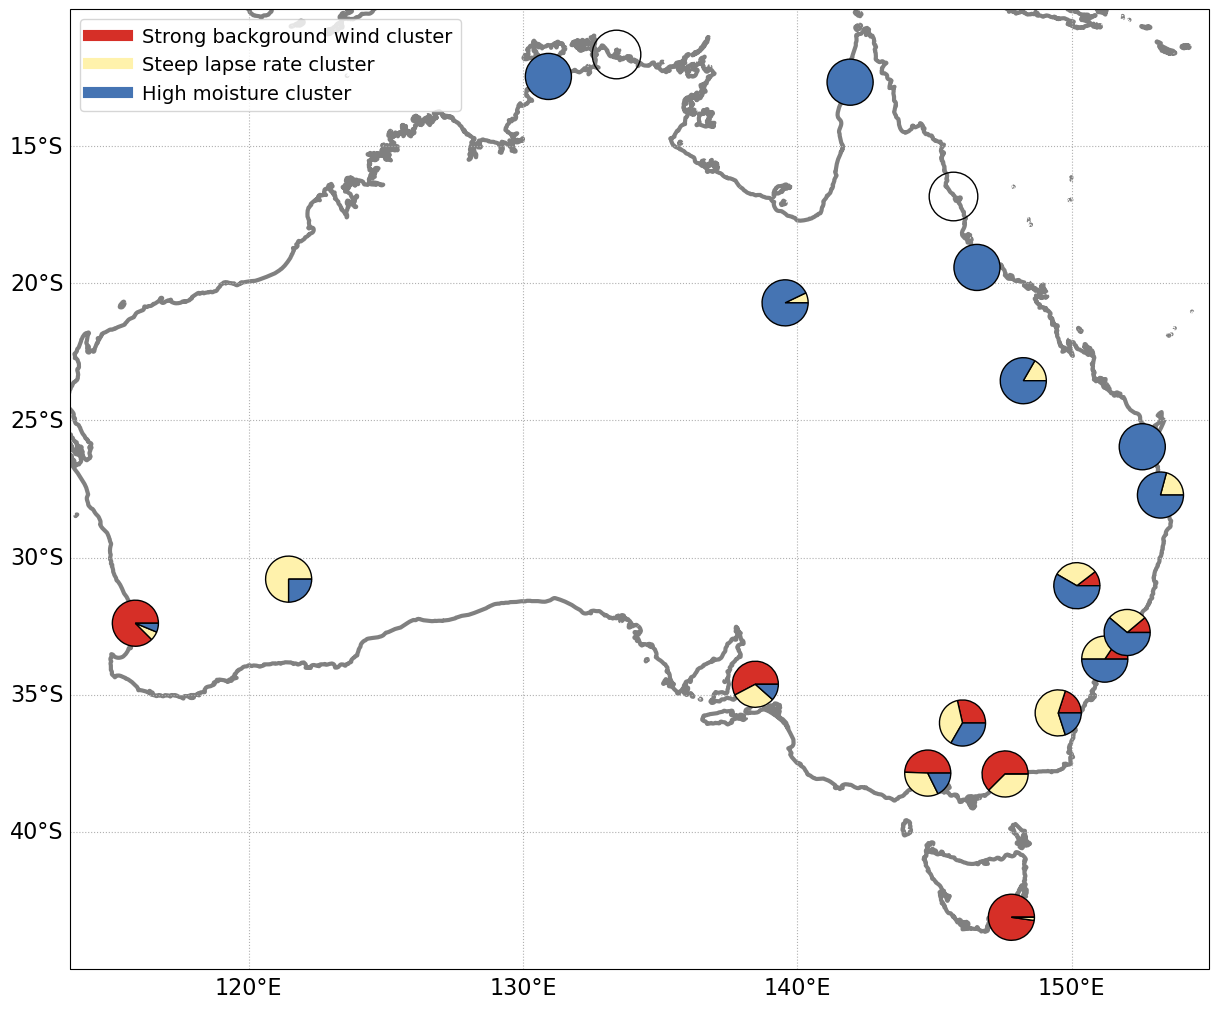

In [44]:
fig=plt.figure(figsize=[16,12])
ax0 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
ax0.coastlines("10m",color="gray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

for rid in rids:
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]   

    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)
    
    n_events = df_scw[df_scw.rid==rid].shape[0]
    if n_events > 0:
        width_height = 0.06
        ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                            width_height,width_height),anchor="C")
        ax1.pie([(df_scw[df_scw.rid==rid].cluster_new == c).sum() for c in [0,1,2]],
               colors=p,wedgeprops={"edgecolor":"k","lw":1})
    else:
        ax0.plot(lon0,lat0,"o",color="k",ms=35,mew=1,mfc="none")

custom_lines = [Line2D([0], [0], color=p[0], lw=8),
                Line2D([0], [0], color=p[1], lw=8),
                Line2D([0], [0], color=p[2], lw=8)]
plt.legend(custom_lines, ["Strong background wind cluster","Steep lapse rate cluster","High moisture cluster"], fontsize=14,loc=2)    

plt.savefig("/g/data/eg3/ab4502/ExtremeWind/cluster_map_no_scaling.jpeg",dpi=400,bbox_inches="tight")

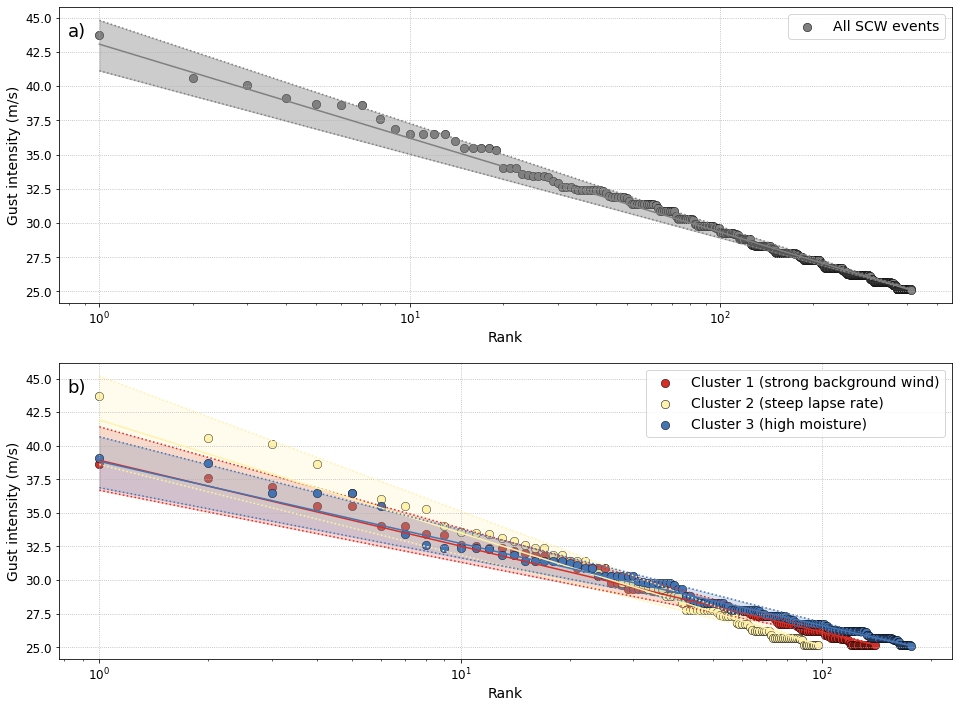

In [10]:
def fit_patero(data,X=np.linspace(0.002,1,1000),model=scipy.stats.gamma):
    
    try:
        shape, location, scale = model.fit(data)
        y=model.isf(X,shape,loc=location,scale=scale)
    except:
        location, scale = model.fit(data)
        y=model.isf(X,loc=location,scale=scale)        
    
    return X*len(data),y



plt.figure(figsize=[16,12])

df_scw = assign_storm_class(df_scw)

plt.subplot(2,1,1)
df_sorted = df_scw.sort_values("gust",ascending=False)
df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)
plt.scatter(x=df_sorted["rank"], y=df_sorted["gust"], color="grey", marker="o", edgecolor="k", linewidth=0.5, s=70)
X, y = fit_patero(df_sorted["gust"].values,X=np.linspace(1/(df_sorted.shape[0]),1,1000),model=scipy.stats.expon)
plt.plot(X,y,color="grey")

N=1000
y_list = []
for n in np.arange(N):
    ind = np.random.randint(0,high=df_sorted.shape[0],size=df_sorted.shape[0])
    X, temp_y = fit_patero(df_sorted["gust"].values[ind],X=np.linspace(1/(df_sorted.shape[0]),1,1000),model=scipy.stats.expon)
    y_list.append(temp_y)      
plt.fill_between(X,
                 np.percentile(np.stack(y_list),2.5,axis=0),
                 np.percentile(np.stack(y_list),97.5,axis=0),
                 color="grey",
                 alpha=0.4)   
plt.plot(X,np.percentile(np.stack(y_list),2.5,axis=0),color="grey",ls=":")
plt.plot(X,np.percentile(np.stack(y_list),97.5,axis=0),color="grey",ls=":")

plt.gca().grid(ls=":")

plt.xscale("log")
plt.yscale("linear")

plt.ylabel("Gust intensity (m/s)",size=14)
plt.xlabel("Rank",size=14)

plt.gca().tick_params(labelsize=12)
plt.legend(labels=["All SCW events"], fontsize=14)

plt.gca().text(0.01,0.9,"a)",size=18,transform=plt.gca().transAxes)

plt.subplot(2,1,2)
scatters=[]
models=[scipy.stats.expon,scipy.stats.expon,scipy.stats.expon]
for c in [0,1,2]:
    
    df_sorted = df_scw[df_scw.cluster_new==c].sort_values("gust",ascending=False)
    df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)       

    scatters.append(plt.scatter(x=df_sorted["rank"], y=df_sorted["gust"], color=p[c], marker="o", edgecolor="k", linewidth=0.5, s=70))
    X, y = fit_patero(df_sorted["gust"].values,X=np.linspace(1/(df_sorted.shape[0]),1,1000),model=models[c])
    plt.plot(X,y,color=p[c])
    
    N=1000
    y_list = []
    for n in np.arange(N):
        ind = np.random.randint(0,high=df_sorted.shape[0],size=df_sorted.shape[0])
        X, temp_y = fit_patero(df_sorted["gust"].values[ind],X=np.linspace(1/(df_sorted.shape[0]),1,1000),model=models[c])
        y_list.append(temp_y)      
    plt.fill_between(X,
                     np.percentile(np.stack(y_list),2.5,axis=0),
                     np.percentile(np.stack(y_list),97.5,axis=0),
                     color=p[c],
                     alpha=0.2,ls="-")   
    plt.plot(X,np.percentile(np.stack(y_list),2.5,axis=0),color=p[c],ls=":")
    plt.plot(X,np.percentile(np.stack(y_list),97.5,axis=0),color=p[c],ls=":")
    
plt.gca().grid(ls=":")

plt.xscale("log")
plt.yscale("linear")

plt.ylabel("Gust intensity (m/s)",size=14)
plt.xlabel("Rank",size=14)

plt.gca().tick_params(labelsize=12)

plt.legend(scatters,["Cluster 1 (strong background wind)","Cluster 2 (steep lapse rate)","Cluster 3 (high moisture)"], fontsize=14)

plt.gca().text(0.01,0.9,"b)",size=18,transform=plt.gca().transAxes)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/rank_gust_dist.jpeg",dpi=400,bbox_inches="tight")


# plt.figure(figsize=[16,6])
# scatters=[]
# cnt=0
# markers=["o","X","^","d","+","x"]
# for cl in ["Cellular","Cell cluster","Non-linear","Linear","Embedded supercell","Supercellular"]:
    
#     df_sorted = df_scw[df_scw.class2==cl].sort_values("gust",ascending=False)
#     df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)       

#     scatters.append(plt.scatter(x=df_sorted["rank"], y=df_sorted["gust"], marker=markers[cnt], edgecolor="k", linewidth=0.5, s=70))
#     cnt=cnt+1
                                                                                         
# plt.gca().grid(ls=":")

# #plt.xscale("log")
# plt.yscale("linear")

# plt.ylabel("Gust intensity (m/s)",size=14)
# plt.xlabel("Rank",size=14)

# plt.gca().tick_params(labelsize=12)

# plt.legend(labels=["Cellular","Cell cluster","Non-linear","Linear","Embedded supercell","Supercellular"], fontsize=14)

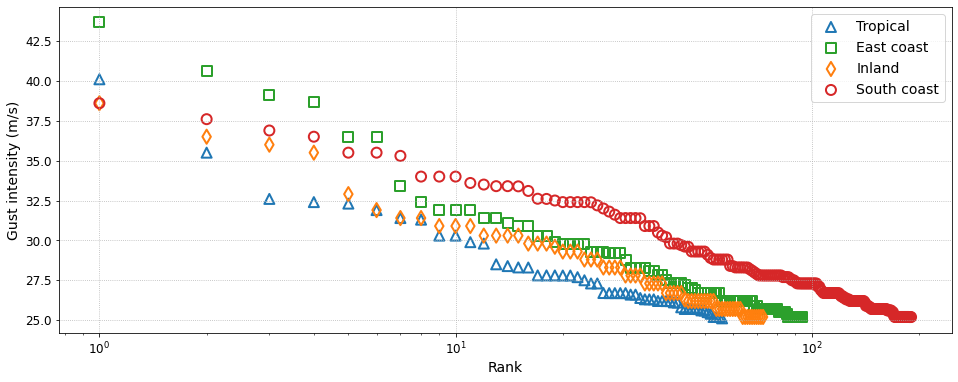

In [11]:
plt.figure(figsize=[16,6])
scatters=[]
cnt=0
markers=["^","s","d","o"]
cols = ["tab:blue","tab:green","tab:orange","tab:red"]
for rid in [tropical_rids,subtrop_rids,inland_rids,midlat_rids]:
    
    df_sorted = df_scw[np.in1d(df_scw.rid,rid)].sort_values("gust",ascending=False)
    df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)       

    scatters.append(plt.scatter(x=df_sorted["rank"], y=df_sorted["gust"], marker=markers[cnt], s=100, linewidth=2, facecolor="none",edgecolor=cols[cnt]))

    cnt=cnt+1
                                                                                         
plt.gca().grid(ls=":")

plt.xscale("log")
plt.yscale("linear")

plt.ylabel("Gust intensity (m/s)",size=14)
plt.xlabel("Rank",size=14)

plt.gca().tick_params(labelsize=12)

plt.legend(labels=["Tropical","East coast","Inland","South coast"], fontsize=14)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/rank_gust_dist_loc.jpeg",dpi=400,bbox_inches="tight")

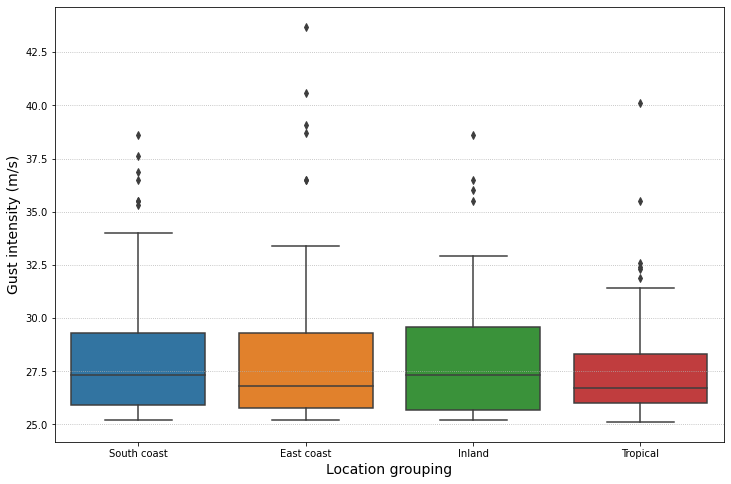

In [12]:
plt.figure(figsize=[12,8])

location_group = []
for i in np.arange(df_scw.shape[0]):
    if df_scw.iloc[i].rid in tropical_rids:
        location_group.append("Tropical")
    elif df_scw.iloc[i].rid in subtrop_rids:
        location_group.append("East coast")
    elif df_scw.iloc[i].rid in inland_rids:
        location_group.append("Inland")
    elif df_scw.iloc[i].rid in midlat_rids:
        location_group.append("South coast")        
df_scw["location_group"] = location_group

#sns.violinplot(data=df_scw,x="location_group",y="gust",cut=0,inner="points")
sns.boxplot(data=df_scw,x="location_group",y="gust")

plt.ylabel("Gust intensity (m/s)",size=14)
plt.xlabel("Location grouping",size=14)

plt.gca().grid(axis="y",ls=":")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/gust_boxplot_loc.jpeg",dpi=400,bbox_inches="tight")

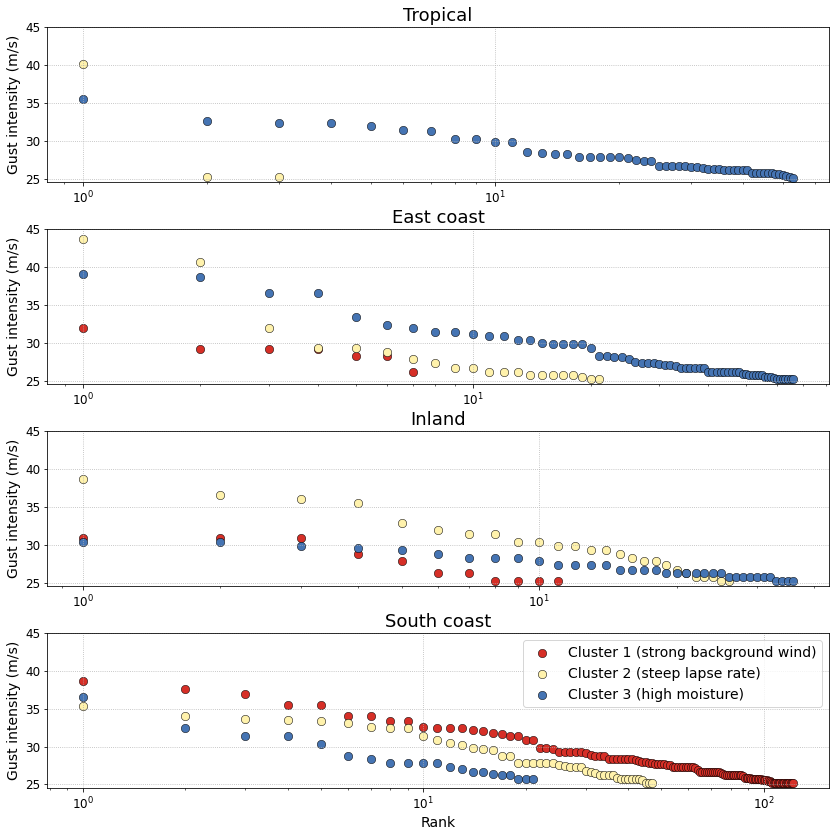

In [13]:
def temp_plot(rid, ax, title, fit_func=False, leg=False):

    scatters=[]
    models=[scipy.stats.expon,scipy.stats.expon,scipy.stats.expon]
    for c in [0,1,2]:

        df_sorted = df_scw[(df_scw.cluster_new==c) & (np.in1d(df_scw.rid,rid))].sort_values("gust",ascending=False)

        if df_sorted.shape[0] > 0:

            df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)       

            scatters.append(ax.scatter(x=df_sorted["rank"], y=df_sorted["gust"], color=p[c], marker="o", edgecolor="k", linewidth=0.5, s=70))

            if fit_func:
                X, y = fit_patero(df_sorted["gust"].values,X=np.linspace(1/(df_sorted.shape[0]),1,1000),model=models[c])
                plt.plot(X,y,color=p[c])                
                
                N=100
                y_list = []
                for n in np.arange(N):
                    ind = np.random.randint(0,high=df_sorted.shape[0],size=df_sorted.shape[0])
                    X, temp_y = fit_patero(df_sorted["gust"].values[ind],X=np.linspace(1/(df_sorted.shape[0]),1,1000),model=models[c])
                    y_list.append(temp_y)      
                ax.fill_between(X,
                                 np.percentile(np.stack(y_list),5,axis=0),
                                 np.percentile(np.stack(y_list),95,axis=0),
                                 color=p[c],
                                 alpha=0.2,ls="-")   
                ax.plot(X,np.percentile(np.stack(y_list),5,axis=0),color=p[c],ls=":")
                ax.plot(X,np.percentile(np.stack(y_list),95,axis=0),color=p[c],ls=":")

    plt.gca().grid(ls=":")

    plt.xscale("log")
    plt.yscale("linear")

    plt.ylabel("Gust intensity (m/s)",size=14)
#    plt.xlabel("Rank",size=14)
    plt.title(title,size=18)

    plt.gca().tick_params(labelsize=12)

    ax.set_ylim([24.5,45])
    
    if leg:
        plt.legend(scatters,["Cluster 1 (strong background wind)","Cluster 2 (steep lapse rate)","Cluster 3 (high moisture)"], fontsize=14)
    
plt.figure(figsize=[14,14])    
temp_plot(tropical_rids,plt.subplot(4,1,1),"Tropical")
temp_plot(subtrop_rids,plt.subplot(4,1,2),"East coast")
temp_plot(inland_rids,plt.subplot(4,1,3),"Inland")
temp_plot(midlat_rids,plt.subplot(4,1,4),"South coast",leg=True); plt.xlabel("Rank",size=14)
plt.subplots_adjust(hspace=.3)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/rank_gust_dist_loc2.jpeg",dpi=400,bbox_inches="tight")

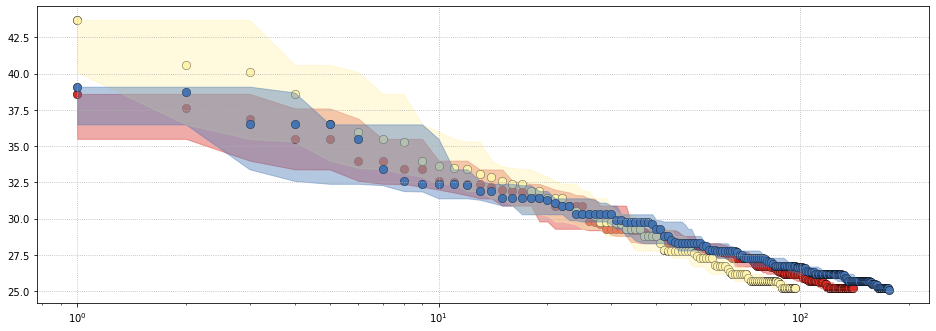

In [14]:
def rank_boot(df_sorted, N):

    y_list = []
    for n in np.arange(N):
        ind = np.random.randint(0,high=df_sorted.shape[0],size=df_sorted.shape[0])
        y_list.append(df_sorted["gust"].iloc[ind].sort_values(ascending=False))

    return np.percentile(np.stack(y_list),5,axis=0), np.percentile(np.stack(y_list),95,axis=0)
    
plt.figure(figsize=[16,12])

df_scw = assign_storm_class(df_scw)

plt.subplot(2,1,1)

for c in [0,1,2]:
    df_sorted = df_scw[df_scw.cluster_new==c].sort_values("gust",ascending=False)
    df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)
    plt.scatter(x=df_sorted["rank"], y=df_sorted["gust"], color=p[c], marker="o", edgecolor="k", linewidth=0.5, s=70)
    plt.gca().grid(ls=":")

    df_sorted_5, df_sorted_95 = rank_boot(df_sorted, 1000)
    plt.fill_between(df_sorted["rank"], df_sorted_5, df_sorted_95, color=p[c],alpha=0.4)
    
plt.xscale("log")
# plt.yscale("linear")

# plt.ylabel("Gust intensity (m/s)",size=14)
# plt.xlabel("Rank",size=14)

# plt.gca().tick_params(labelsize=12)
# plt.legend(labels=["All SCW events"], fontsize=14)

KstestResult(statistic=0.07411622276029056, pvalue=0.0757889205186723)
KstestResult(statistic=0.147, pvalue=0.008808993995002332)
KstestResult(statistic=0.1277319587628866, pvalue=0.10154947773649005)
KstestResult(statistic=0.07968181818181819, pvalue=0.2811321790518187)


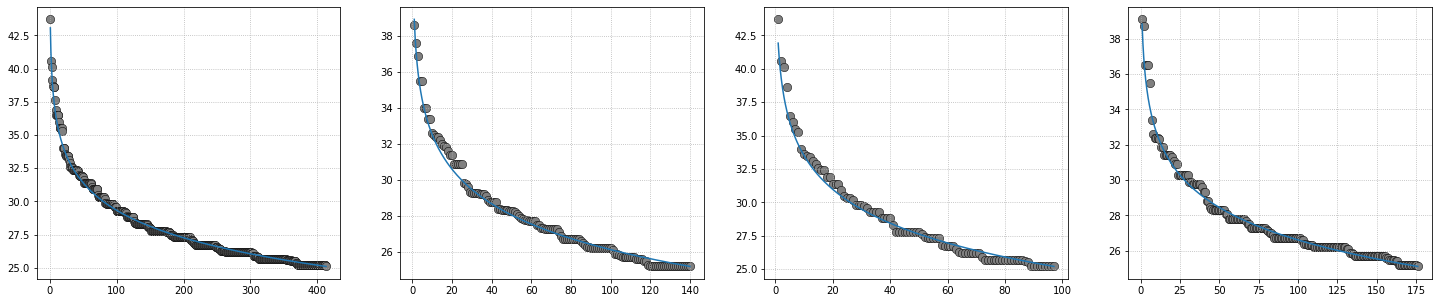

In [15]:
plt.figure(figsize=[25,5])
model=scipy.stats.expon
    
for c in [-1,0,1,2]:
    plt.subplot(1,4,c+2)
    
    if c >= 0:
        df_sorted = df_scw[df_scw.cluster_new==c].sort_values("gust",ascending=False)
    else:
        df_sorted = df_scw.sort_values("gust",ascending=False)
    df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)

    X=np.linspace(1/df_sorted.shape[0],1,1000)
    
    # a,location,scale = model.fit(df_sorted.gust.values,method="MLE")
    # y=model.isf(X,a,loc=location,scale=scale)
    location,scale = model.fit(df_sorted.gust.values)
    y=model.isf(X,loc=location,scale=scale)    

    plt.scatter(x=df_sorted["rank"], y=df_sorted["gust"], color="grey", marker="o", edgecolor="k", linewidth=0.5, s=70)
    plt.gca().grid(ls=":")

    plt.plot(X*df_sorted.shape[0],y)
    print(scipy.stats.ks_2samp(df_sorted.gust.values,y,alternative="two-sided"))
    #plt.xscale("log")

In [16]:
ks = {0:[],1:[],2:[]}

for c in [0,1,2]:
    for c1 in [0,1,2]:

        ks[c].append(scipy.stats.ks_2samp(df_scw[df_scw.cluster_new==c].gust.values,
                                   df_scw[df_scw.cluster_new==c1].gust.values,
                                   alternative="two-sided")[1])
        
pd.DataFrame(ks)

,0,1,2
0,1.000000,0.217325,0.428609
1,0.217325,1.000000,0.050506
2,0.428609,0.050506,1.000000


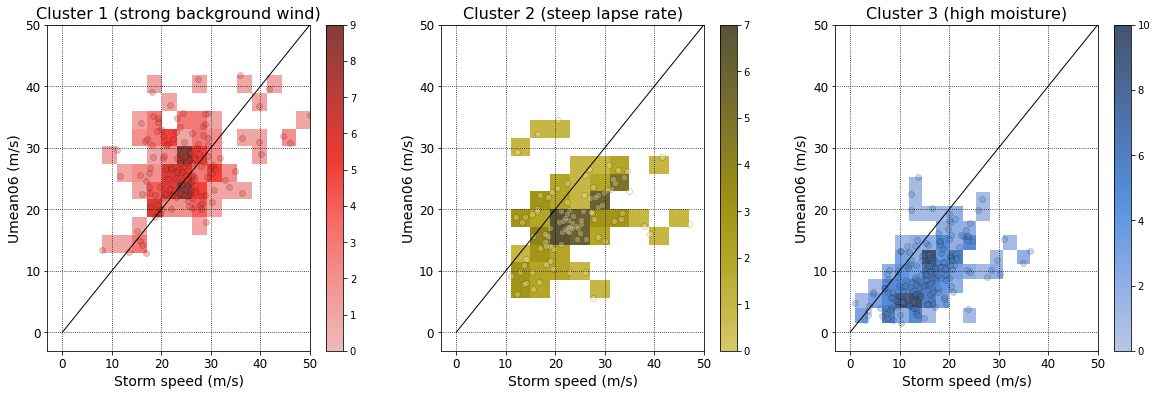

In [35]:
plt.figure(figsize=[20,6])

wind_var="Umean06"

ax=plt.subplot(1,3,1)
#sns.kdeplot(x=df_scw[df_scw.cluster_new==0].speed.values,y=df_scw[df_scw.cluster_new==0][wind_var].values,ax=ax,color=p[0],fill=True,thresh=0.025)
sns.histplot(x=df_scw[df_scw.cluster_new==0].speed.values,y=df_scw[df_scw.cluster_new==0][wind_var].values,ax=ax,color=p[0],
             cbar=True)
sns.scatterplot(data=df_scw[df_scw.cluster_new==0],x="speed",y=wind_var,ax=ax,color=p[0],edgecolor="k",alpha=0.3)
ax.plot([0,50],[0,50],color="k",ls="-",lw=1)
ax.set_xlim([-3,50])
ax.set_ylim([-3,50])
ax.grid(ls=":",color="k")
ax.set_xlabel("Storm speed (m/s)",size=14)
ax.set_ylabel(wind_var+" (m/s)",size=14)
ax.tick_params(labelsize=12)
ax.set_title("Cluster 1 (strong background wind)",size=16)

ax=plt.subplot(1,3,2)
#sns.kdeplot(x=df_scw[df_scw.cluster_new==1].speed.values,y=df_scw[df_scw.cluster_new==1][wind_var].values,ax=ax,color=p[1],fill=True,thresh=0.025)
sns.histplot(x=df_scw[df_scw.cluster_new==1].speed.values,y=df_scw[df_scw.cluster_new==1][wind_var].values,ax=ax,color=p[1],
             cbar=True)
sns.scatterplot(data=df_scw[df_scw.cluster_new==1],x="speed",y=wind_var,ax=ax,color=p[1],edgecolor="k",alpha=0.3)
ax.plot([0,50],[0,50],color="k",ls="-",lw=1)
ax.set_xlim([-3,50])
ax.set_ylim([-3,50])
ax.grid(ls=":",color="k")
ax.set_xlabel("Storm speed (m/s)",size=14)
ax.set_ylabel(wind_var+" (m/s)",size=14)
ax.tick_params(labelsize=12)
ax.set_title("Cluster 2 (steep lapse rate)",size=16)

ax=plt.subplot(1,3,3)
# sns.kdeplot(x=df_scw[df_scw.cluster_new==2].speed.values,y=df_scw[df_scw.cluster_new==2][wind_var].values,ax=ax,color=p[2],fill=True,thresh=0.025,
#             cbar=True,cumulative=False)
sns.histplot(x=df_scw[df_scw.cluster_new==2].speed.values,y=df_scw[df_scw.cluster_new==2][wind_var].values,ax=ax,color=p[2],
             cbar=True)
sns.scatterplot(data=df_scw[df_scw.cluster_new==2],x="speed",y=wind_var,ax=ax,color=p[2],edgecolor="k",alpha=0.3)
ax.plot([0,50],[0,50],color="k",ls="-",lw=1)
ax.set_xlim([-3,50])
ax.set_ylim([-3,50])
ax.grid(ls=":",color="k")
ax.set_xlabel("Storm speed (m/s)",size=14)
ax.set_ylabel(wind_var+" (m/s)",size=14)
ax.tick_params(labelsize=12)
ax.set_title("Cluster 3 (high moisture)",size=16)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/Umean06_storm_speed.jpeg",bbox_inches="tight",dpi=300)

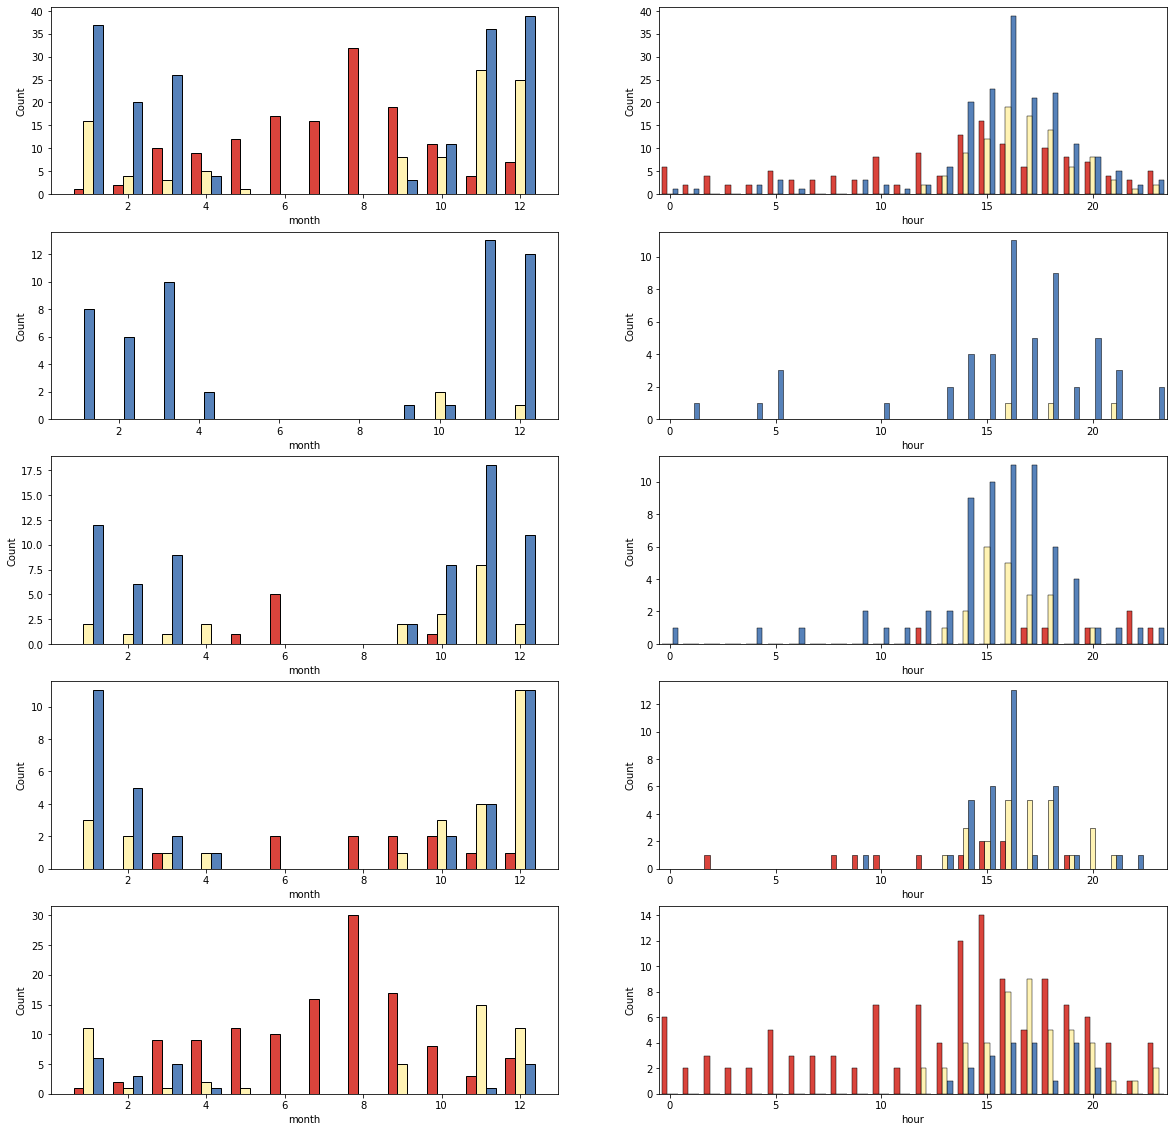

In [18]:
def plot_hist_seasonal(df,ax):
    sns.histplot(x="month",data=df,
             discrete=True,hue="cluster_new",multiple="dodge",palette=p, legend=False, stat="count", kde=False, alpha=0.9,
            line_kws={"lw":3},common_norm=True,hue_order=[0,1,2],ax=ax,shrink=0.75)
    
def plot_hist_diurnal(df,ax):
    sns.histplot(x="hour",data=df,
             discrete=True,hue="cluster_new",multiple="dodge",palette=p, legend=False, stat="count", kde=False, alpha=0.9,
            line_kws={"lw":3},common_norm=True,hue_order=[0,1,2],ax=ax,shrink=0.75)
    plt.xlim([-0.5,23.5])

plt.figure(figsize=[20,20])

plot_hist_seasonal(df_scw.drop(columns="dt_utc").reset_index(),plt.subplot(5,2,1))
plot_hist_seasonal(df_scw[np.in1d(df_scw.rid,tropical_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,3))
plot_hist_seasonal(df_scw[np.in1d(df_scw.rid,subtrop_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,5))
plot_hist_seasonal(df_scw[np.in1d(df_scw.rid,inland_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,7))
plot_hist_seasonal(df_scw[np.in1d(df_scw.rid,midlat_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,9))

plot_hist_diurnal(df_scw.drop(columns="dt_utc").reset_index(),plt.subplot(5,2,2))
plot_hist_diurnal(df_scw[np.in1d(df_scw.rid,tropical_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,4))
plot_hist_diurnal(df_scw[np.in1d(df_scw.rid,subtrop_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,6))
plot_hist_diurnal(df_scw[np.in1d(df_scw.rid,inland_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,8))
plot_hist_diurnal(df_scw[np.in1d(df_scw.rid,midlat_rids)].drop(columns="dt_utc").reset_index(),plt.subplot(5,2,10))


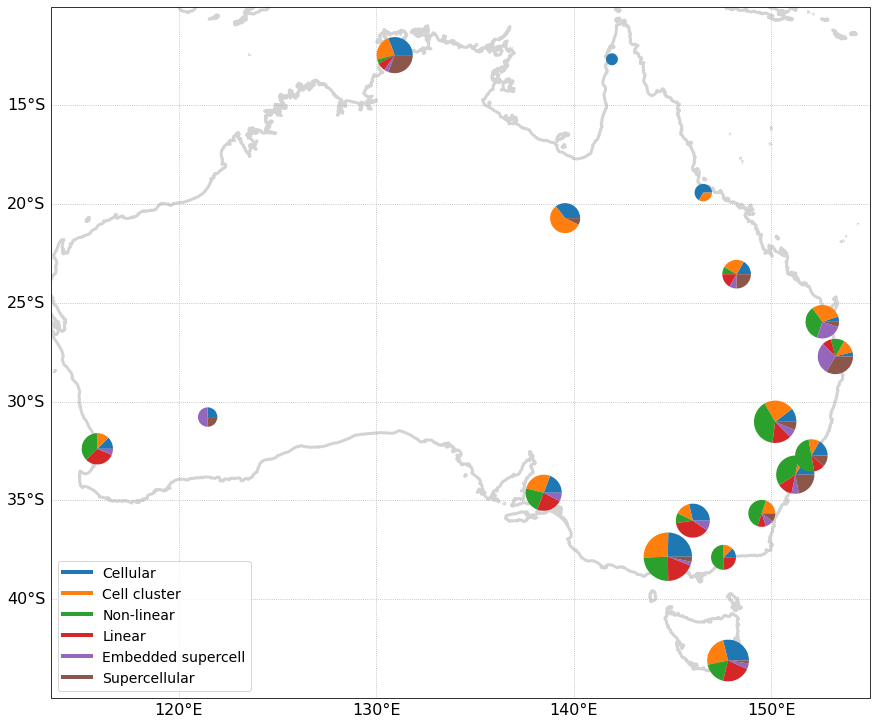

In [19]:
fig=plt.figure(figsize=[16,12])

order = ["Cellular","Cell cluster","Non-linear","Linear","Embedded supercell","Supercellular"]

ax0 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
ax0.coastlines("10m",color="lightgray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

for rid in rids:
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]   

    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)

    n_events = df_scw[df_scw.rid==rid].shape[0]
    #width_height = 0.08
    #width_height = n_events/153 * 0.1
    width_height = (np.log(n_events+2)/153) * 3
    
    if n_events > 0:
        ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                            width_height,width_height),anchor="C")
        ax1.pie([(df_scw[df_scw.rid==rid].class2 == o).sum() for o in order])
    else:
        pass

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="tab:blue", lw=4),
                Line2D([0], [0], color="tab:orange", lw=4),
                Line2D([0], [0], color="tab:green", lw=4),
                Line2D([0], [0], color="tab:red", lw=4),
                Line2D([0], [0], color="tab:purple", lw=4),
                Line2D([0], [0], color="tab:brown", lw=4)]
plt.legend(custom_lines, order, fontsize=14,loc=3)    
    

Text(0.5, 0, 'Radar ID')

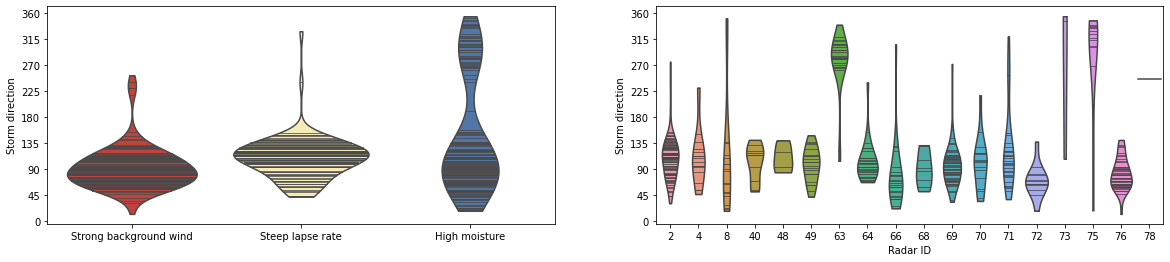

In [20]:
plt.figure(figsize=[20,4])

plt.subplot(1,2,1)
sns.violinplot(data=df_scw[["angle","cluster_new"]],y="angle",inner="stick",x="cluster_new",cut=0,palette=p,order=[0,1,2])
_=plt.yticks(np.arange(0,360+45,45))
plt.ylabel("Storm direction")
plt.xticks([0,1,2],["Strong background wind","Steep lapse rate","High moisture"])
plt.xlabel("")

plt.subplot(1,2,2)
sns.violinplot(data=df_scw[["angle","cluster_new","rid"]].astype({"rid":int}).sort_values("rid"),y="angle",inner="stick",x="rid",cut=0)
_=plt.yticks(np.arange(0,360+45,45))
plt.ylabel("Storm direction")
plt.xlabel("Radar ID")

<AxesSubplot:xlabel='rid', ylabel='gust'>

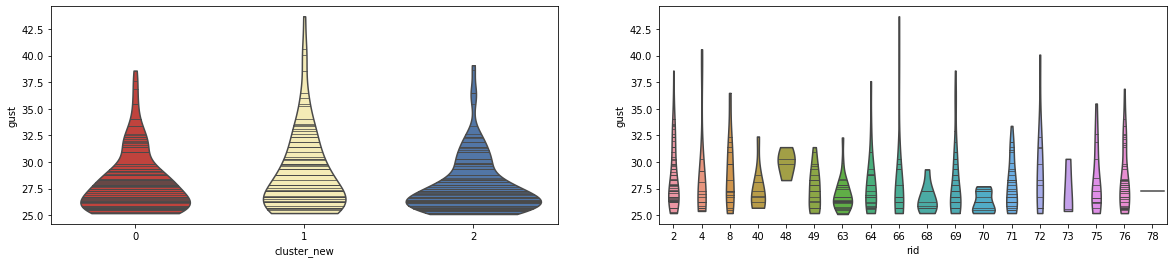

In [21]:
plt.figure(figsize=[20,4])

plt.subplot(1,2,1)
sns.violinplot(data=df_scw[["gust","cluster_new"]],y="gust",inner="stick",x="cluster_new",cut=0,palette=p,order=[0,1,2])

plt.subplot(1,2,2)
sns.violinplot(data=df_scw[["gust","cluster_new","rid"]].astype({"rid":int}).sort_values("rid"),y="gust",inner="stick",x="rid",cut=0)


In [22]:
[print(df_scw[df_scw.class2==c].sort_values("gust",ascending=False)[["class2","rid","gust"]].iloc[0],"\n") for c in ["Cellular","Cell cluster","Non-linear","Linear","Embedded supercell","Supercellular"]]

class2    Cellular
rid             75
gust          35.5
Name: 2014-01-25 03:48:00, dtype: object 

class2    Cell cluster
rid                 69
gust              38.6
Name: 2016-12-08 09:39:00, dtype: object 

class2    Non-linear
rid                4
gust            40.6
Name: 2020-11-16 09:07:00, dtype: object 

class2    Linear
rid            2
gust        38.6
Name: 2009-04-14 19:15:00, dtype: object 

class2    Embedded supercell
rid                       76
gust               36.888889
Name: 2014-02-09 04:06:00, dtype: object 

class2    Supercellular
rid                  66
gust               43.7
Name: 2016-11-13 07:31:00, dtype: object 



[None, None, None, None, None, None]

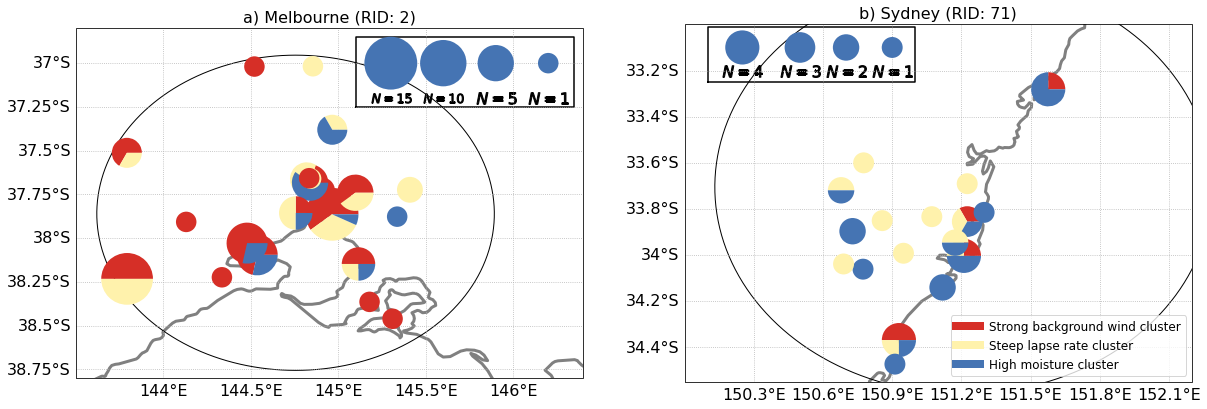

In [23]:
def add_legend(n_events, point, ax0, pad=0.1):

    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)
    width_height = (np.log(n_events+2)/15)

    ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
    ax1.pie([0,0,n_events],colors=p)
    ax0.plot(point[0],point[1]-pad,marker="$N="+str(n_events)+"$",ms=40,ls="none",color="k")

fig=plt.figure(figsize=[20,10])
ax0 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_xlim([143.5,146.4])
ax0.set_ylim([-38.8,-36.8])
ax0.coastlines("10m",color="gray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

rid="2"
temp_df = df_scw[df_scw.rid==rid]
names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                        "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+"vic"+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
    names=names, header=0)  

for stn in temp_df.stn_id.unique():
    
    lon0 = stn_df[stn_df.stn_no==stn].lon.values[0]
    lat0 = stn_df[stn_df.stn_no==stn].lat.values[0]    
    
    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)

    n_events=temp_df[temp_df.stn_id==stn].shape[0]
    width_height = (np.log(n_events+2)/15)
    
    ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                        width_height,width_height),anchor="C")
    ax1.pie([(temp_df[temp_df.stn_id==stn].cluster_new == c).sum() for c in [0,1,2]],
           colors=p)

    
add_legend(15,(145.3,-37),ax0,pad=0.2)
add_legend(10,(145.6,-37),ax0,pad=0.2)
add_legend(5,(145.9,-37),ax0,pad=0.2)
add_legend(1,(146.2,-37),ax0,pad=0.2)
ax0.plot([145.1,146.35,146.35,145.1,145.1],[-37.25,-37.25,-36.85,-36.85,-37.25],color="k")    
    
plot_range_rings(144.7555,-37.8553,100,ax0)

plt.title("a) Melbourne (RID: 2)",size=16)
    

ax0 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_xlim([150,152.2])
ax0.set_ylim([-34.55,-33])
ax0.coastlines("10m",color="gray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

rid="71"
temp_df = df_scw[df_scw.rid==rid]
names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                        "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+"nsw"+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
    names=names, header=0)  

for stn in temp_df.stn_id.unique():
    
    lon0 = stn_df[stn_df.stn_no==stn].lon.values[0]
    lat0 = stn_df[stn_df.stn_no==stn].lat.values[0]    
    
    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)

    n_events=temp_df[temp_df.stn_id==stn].shape[0]
    width_height = (np.log(n_events+2)/15)
    
    ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                        width_height,width_height),anchor="C")
    ax1.pie([(temp_df[temp_df.stn_id==stn].cluster_new == c).sum() for c in [0,1,2]],
           colors=p)
    
add_legend(4,(150.25,-33.1),ax0)
add_legend(3,(150.5,-33.1),ax0)
add_legend(2,(150.7,-33.1),ax0)
add_legend(1,(150.9,-33.1),ax0)
ax0.plot([150.1,151,151,150.1,150.1],[-33.25,-33.25,-33.01,-33.01,-33.25],color="k")

plot_range_rings(151.2094,-33.7008,100,ax0)

plt.title("b) Sydney (RID: 71)",size=16)

custom_lines = [Line2D([0], [0], color=p[0], lw=8),
                Line2D([0], [0], color=p[1], lw=8),
                Line2D([0], [0], color=p[2], lw=8)]
plt.legend(custom_lines, ["Strong background wind cluster","Steep lapse rate cluster","High moisture cluster"], fontsize=12,loc=4) 
#plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/sub_radar_domain_variability.jpeg",dpi=400,bbox_inches="tight")

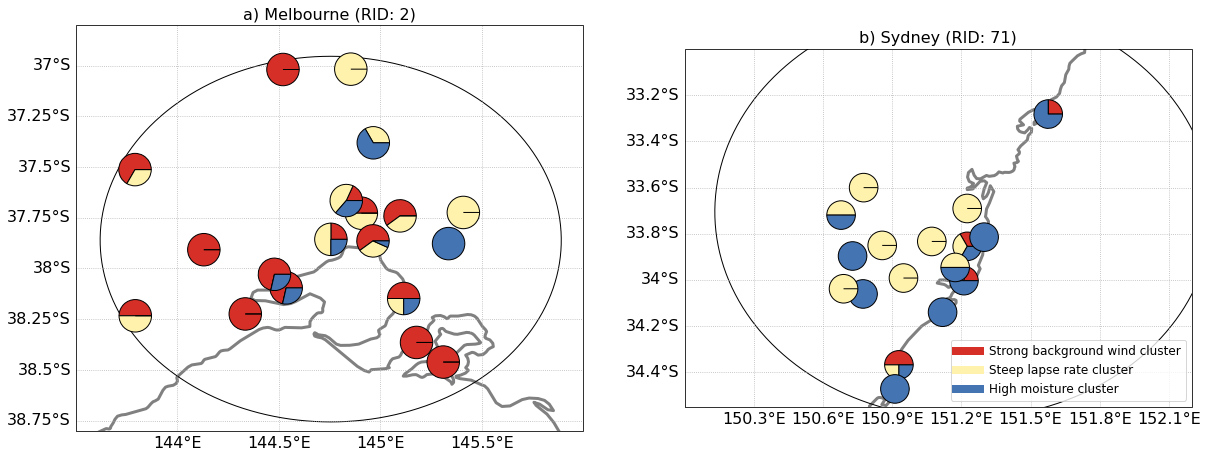

In [38]:
fig=plt.figure(figsize=[20,10])
ax0 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_xlim([143.5,146])
ax0.set_ylim([-38.8,-36.8])
ax0.coastlines("10m",color="gray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

rid="2"
temp_df = df_scw[df_scw.rid==rid]
names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                        "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+"vic"+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
    names=names, header=0)  

for stn in temp_df.stn_id.unique():
    
    lon0 = stn_df[stn_df.stn_no==stn].lon.values[0]
    lat0 = stn_df[stn_df.stn_no==stn].lat.values[0]    
    
    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)

    width_height = .1     
    
    if stn == 86282:
        ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                            width_height,width_height),anchor="C")           
        ax1.pie([(temp_df[np.in1d(temp_df.stn_id, [86395,86396,86397,86398])].cluster_new == c).sum() for c in [0,1,2]],
               colors=p,wedgeprops={"edgecolor":"k","lw":1})        
    elif stn in [86395,86396,86397,86398]:
        pass
    else:
        ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                            width_height,width_height),anchor="C")           
        ax1.pie([(temp_df[temp_df.stn_id==stn].cluster_new == c).sum() for c in [0,1,2]],
               colors=p,wedgeprops={"edgecolor":"k","lw":1})
    
plot_range_rings(144.7555,-37.8553,100,ax0)

plt.title("a) Melbourne (RID: 2)",size=16)
    

ax0 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_xlim([150,152.2])
ax0.set_ylim([-34.55,-33])
ax0.coastlines("10m",color="gray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

rid="71"
temp_df = df_scw[df_scw.rid==rid]
names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                        "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+"nsw"+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
    names=names, header=0)  

for stn in temp_df.stn_id.unique():
    
    lon0 = stn_df[stn_df.stn_no==stn].lon.values[0]
    lat0 = stn_df[stn_df.stn_no==stn].lat.values[0]    
    
    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)

    width_height = .1
    
    ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                        width_height,width_height),anchor="C")
    ax1.pie([(temp_df[temp_df.stn_id==stn].cluster_new == c).sum() for c in [0,1,2]],
           colors=p,wedgeprops={"edgecolor":"k","lw":1})
    
plot_range_rings(151.2094,-33.7008,100,ax0)

plt.title("b) Sydney (RID: 71)",size=16)

custom_lines = [Line2D([0], [0], color=p[0], lw=8),
                Line2D([0], [0], color=p[1], lw=8),
                Line2D([0], [0], color=p[2], lw=8)]
plt.legend(custom_lines, ["Strong background wind cluster","Steep lapse rate cluster","High moisture cluster"], fontsize=12,loc=4) 

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/sub_radar_domain_variability.jpeg",dpi=400,bbox_inches="tight")

In [42]:
df_scw[["azi_shear","class2"]].sort_values("azi_shear")

,azi_shear,class2
dt_utc,,
2013-01-13 07:01:00,0.000,Non-linear
2013-01-18 07:51:00,0.625,Cellular
2012-12-04 04:07:00,0.688,Cellular
2013-08-12 02:50:00,0.727,Cellular
2014-01-16 06:17:00,0.742,Cellular
...,...,...
2016-03-17 23:57:00,NaN,Non-linear
2016-07-22 18:51:00,NaN,Non-linear
2016-10-04 07:35:00,NaN,Cell cluster
